In [ ]:
# make torch imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable as Var

# make other relevant imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Define the NN
class NN(nn.Module):

  def __init__(self):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(3, 30)  # Fully connected layers
    self.fc2 = nn.Linear(30, 30)
    self.fc3 = nn.Linear(30, 30)
    self.fc4 = nn.Linear(30, 30)
    self.fc5 = nn.Linear(30, 3)

  def forward(self, x):
    x.requires_grad=True # keep track of gradient for jacobian
    # forward pass
    y = torch.sin(self.fc1(x))
    y = torch.sin(self.fc2(y))
    y = torch.sin(self.fc3(y))
    y = torch.sin(self.fc4(y))
    y = torch.sin(self.fc5(y))

    return y

In [ ]:
################################################################################
# IMPORT DATA FROM CSV FILE 
################################################################################

eff_par = pd.read_csv('EffectiveParameters2.csv')
eig = pd.read_csv('EigenVectors2.csv')

training_size = 7000
validation_size = len(eff_par) - training_size

# training sets 
training_set_1 = eff_par.iloc[0:training_size, :].values
training_set_2 = eig.iloc[0:training_size, :].values

target_set_1 = eig.iloc[0:training_size, :].values
target_set_2 = eff_par.iloc[0:training_size, :].values

# validation sets
validation_set_1 = eff_par.iloc[training_size:, :].values
validation_set_2 = eig.iloc[training_size:, :].values

validation_target_1 = eig.iloc[training_size:, :].values
validation_target_2 = eff_par.iloc[training_size:, :].values

################################################################################
# Convert to Tensors for TORCH
################################################################################
training_set_1 = torch.from_numpy(training_set_1)
training_set_2 = torch.from_numpy(training_set_2)
target_set_1 = torch.from_numpy(target_set_1)
target_set_2 = torch.from_numpy(target_set_2)
validation_set_1 = torch.from_numpy(validation_set_1)
validation_set_2 = torch.from_numpy(validation_set_2)
validation_target_1 = torch.from_numpy(validation_target_1)
validation_target_2 = torch.from_numpy(validation_target_2)

FileNotFoundError: ignored

In [ ]:
################################################################################
# Set Up Training for both directions
################################################################################

# set training and target as Var for training
training_set_1, training_set_2 = Var(training_set_1), Var(training_set_2)
target_set_1, target_set_2 = Var(target_set_1), Var(target_set_2)

# initialize models
model = NN()
model_inverse = NN()

# define loss criterion
criterion = nn.MSELoss(reduction='mean')

optimizer_1 = optim.Adam(model.parameters(), lr=0.01, amsgrad=False)
optimizer_2 = optim.Adam(model_inverse.parameters(), lr=0.01, amsgrad=False)

In [ ]:
################################################################################
# train FORWARD nn
################################################################################

# model.train()
# model.double()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, amsgrad=False)

# for time in range(10000):

#   pred = model(training_set_1)          # make prediction

#   loss = criterion(pred, target_set_1)  # compute loss

#   # backward pass and update
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   if time%100 == 0:
#     print('Epoch: {}, Loss: {}'.format(time, loss.item()))

In [ ]:
# model.eval()
# torch.save(model, 'forward_net') # save model

In [ ]:
# check that results make sense on the validation set:

model = torch.load('forward_net')                         # load model

pred = model(validation_set_1)                            # make prediction
validation_error = criterion(pred, validation_target_1)   # compute error
print("Average MSE Validation Error: {}".format(validation_error.item()))  # print

pred = model(training_set_1)
training_error = criterion(pred, target_set_1)
print("Average MSE Training Error: {}".format(training_error.item()))

# example with a single slice:
x = validation_set_1[0].data
pred = model(x)
err = criterion(pred, validation_target_1[0].data)
# print
print("Input Tensor:     {}".format(x))
print("Predicted Tensor: {}".format(pred.data))
print("Target Tensor:    {}".format(validation_target_1[0].data))
print("MS Error:         {}".format(err))


Average MSE Validation Error: 1.3173261171780165e-06
Average MSE Training Error: 1.3722581191740991e-06
Input Tensor:     tensor([0.5699, 0.4908, 0.5329], dtype=torch.float64, requires_grad=True)
Predicted Tensor: tensor([0.4240, 0.5410, 0.5090], dtype=torch.float64)
Target Tensor:    tensor([0.4241, 0.5412, 0.5096], dtype=torch.float64)
MS Error:         1.5162852830628242e-07


In [ ]:
################################################################################
# train INVERSE net
################################################################################

# model_inverse.train()
# model_inverse.double()
# optimizer = optim.Adam(model_inverse.parameters(), lr=0.0001, amsgrad=False)

# for time in range(10000):

#   pred = model_inverse(training_set_2)          # make prediction

#   loss = criterion(pred, target_set_2)  # compute loss

#   # backward pass and update
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   if time%100 == 0:
#     print('Epoch: {}, Loss: {}'.format(time, loss.item()))


In [ ]:
# save inverse model

# model_inverse.eval() 
# torch.save(model_inverse, 'inverse_net') 

In [ ]:
# check that results make sense on the validation set:

model = torch.load('inverse_net')                         # load model

# print average MSE Validation Error
pred = model(validation_set_2)                            # make prediction
validation_error = criterion(pred, validation_target_2)   # compute error
print("Average MSE Validation Error: {}".format(validation_error.item()))  # print

# print average MSE Training Error
pred = model(training_set_2)                              # make prediction
training_error = criterion(pred, target_set_2)            # compute error
print("Average MSE Training Error: {}".format(training_error.item())) # print

Average MSE Validation Error: 4.65481624781674e-06
Average MSE Training Error: 4.561508151496382e-06


In [ ]:
################################################################################
# Define Determinant of the Jacobian Functions
################################################################################

# This is manual, less useful but it is an example of how you find the gradient
def det_manual(y, x):
  """
  Determinant of the Jacobian (partials of y wrt x)
  y: output tensor [3x1]
  x: input tensor [3x1]
  """
  # compute partials
  d0 = autograd.grad(y[0], x, retain_graph=True)[0]
  d1 = autograd.grad(y[1], x, retain_graph=True)[0]
  d2 = autograd.grad(y[2], x, retain_graph=False)[0] # don't keep the graph

  # compute determinant:
  determinant = d0[0] * (d1[1] * d2[2] - d1[2] * d2[1])
  determinant -= d0[1] * (d1[0] * d2[2] - d1[2] * d2[0])
  determinant += d0[2] * (d1[0] * d2[1] - d1[1] * d2[0])
  

def det(x, net):
  """
  computes det of jacobian of f wrt x
  """
  jac = torch.autograd.functional.jacobian(net, x) #
  jac = np.linalg.det(jac.data.numpy())
  return jac.item()

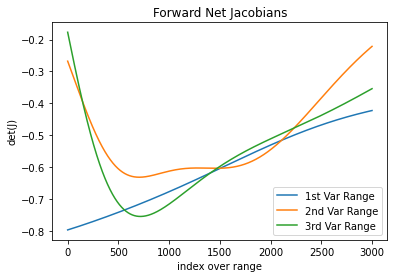

In [ ]:
################################################################################
# Evaluating and Plotting the Jacobian (for the forward net)
################################################################################
# These might need functions of their own later...

# Load Models (redundant):
forward_net = torch.load('forward_net')

# We plot for 2 vars fixed at their mean over the data, whith the third
# variable being uniformly sampled over its range
x0 = eff_par.iloc[:, 0].values
x1 = eff_par.iloc[:, 1].values
x2 = eff_par.iloc[:, 2].values

# fixed 1st and 2nd
range0 = np.linspace(x0.min(), x0.max(), 3000)
range1 = np.linspace(x1.min(), x1.max(), 3000)
range2 = np.linspace(x2.min(), x2.max(), 3000)

jac0 = []
jac1 = []
jac2 = []

for i in range0:
  inp = torch.tensor([i, x1.mean(), x2.mean()])
  jac = det(inp, forward_net)
  jac0.append(jac)

for i in range1:
  inp = torch.tensor([x0.mean(), i, x2.mean()])
  jac = det(inp, forward_net)
  jac1.append(jac)

for i in range2:
  inp = torch.tensor([x0.mean(), x1.mean(), i])
  jac = det(inp, forward_net)
  jac2.append(jac)

plt.title('Forward Net Jacobians')
plt.plot(jac0, label='1st Var Range')
plt.plot(jac1, label='2nd Var Range')
plt.plot(jac2, label='3rd Var Range')
plt.legend()
plt.xlabel('index over range')
plt.ylabel('det(J)')
plt.savefig('Forwad_Net_Jacobians')


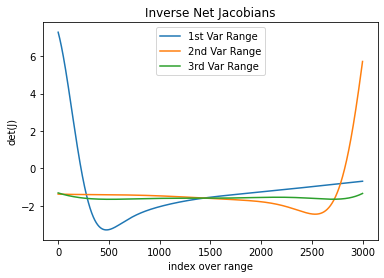

In [ ]:
################################################################################
# Evaluating and Plotting the Jacobian (for the forward net)
################################################################################
# These might need functions of their own later...

# Load Models (redundant):
inverse_net = torch.load('inverse_net')

# We plot for 2 vars fixed at their mean over the data, whith the third
# variable being uniformly sampled over its range
x0 = eig.iloc[:, 0].values
x1 = eig.iloc[:, 1].values
x2 = eig.iloc[:, 2].values

# fixed 1st and 2nd
range0 = np.linspace(x0.min(), x0.max(), 3000)
range1 = np.linspace(x1.min(), x1.max(), 3000)
range2 = np.linspace(x2.min(), x2.max(), 3000)

jac0 = []
jac1 = []
jac2 = []

for i in range0:
  inp = torch.tensor([i, x1.mean(), x2.mean()])
  jac = det(inp, inverse_net)
  jac0.append(jac)

for i in range1:
  inp = torch.tensor([x0.mean(), i, x2.mean()])
  jac = det(inp, inverse_net)
  jac1.append(jac)

for i in range2:
  inp = torch.tensor([x0.mean(), x1.mean(), i])
  jac = det(inp, inverse_net)
  jac2.append(jac)

plt.title('Inverse Net Jacobians')
plt.plot(jac0, label='1st Var Range')
plt.plot(jac1, label='2nd Var Range')
plt.plot(jac2, label='3rd Var Range')
plt.legend()
plt.xlabel('index over range')
plt.ylabel('det(J)')
plt.savefig('Inverse_Net_Jacobians')

At this point, we see that the determinant of the jacobian $(J)$ switches sign at the edges of the plot data. We hope that the data domain that corresponds to the sign-switching is not represented in the data set. (note that for the most part of all graphs $J$ remains negative)

Below, we check that $J$ is negative over the entire data set.

Then, we check that points close to these "edges" are not part of the generated data

In [ ]:
negative_jac = 0

for vector in eig.values:
  x = torch.from_numpy(vector)
  jac = det(x, inverse_net)
  if jac<0:
    negative_jac += 1

print("Inverse Net")
print('number of entries with negative jac: {}'.format(negative_jac))

negative_jac = 0

for vector in eff_par.values:
  x = torch.from_numpy(vector)
  jac = det(x, forward_net)
  if jac < 0:
    negative_jac += 1

print("Forward Net")
print("number of entries with negative jac: {}".format(negative_jac))

Inverse Net
number of entries with negative jac: 9999
Forward Net
number of entries with negative jac: 9999


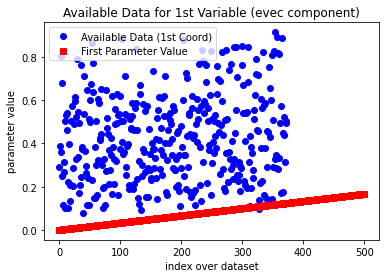

In [ ]:
# note that we care about the 1st and 2nd variable ranges

# for the first variable, keep 2nd and 3rd constant:
neighbors = []

for vector in eig.values:
  e1 = np.abs(vector[1] - x1.mean())
  e2 = np.abs(vector[2] - x2.mean())
  if e1<0.05 and e2<0.05:
    neighbors.append(vector[0])

plt.plot(neighbors, 'bo',label='Available Data (1st Coord)')
plt.plot(range0[0: 500],'rs', label='First Parameter Value')
plt.legend()
plt.xlabel('index over dataset')
plt.ylabel('parameter value')
plt.title('Available Data for 1st Variable (evec component)')
plt.savefig('left_tail')

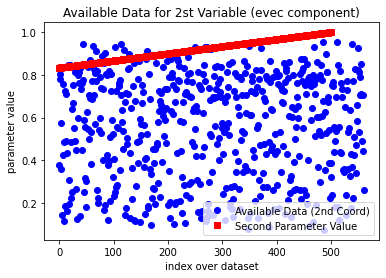

In [ ]:
# note that we care about the 1st and 2nd variable ranges

# for the first variable, keep 2nd and 3rd constant:
neighbors = []

for vector in eig.values:
  e1 = np.abs(vector[0] - x0.mean())
  e2 = np.abs(vector[2] - x2.mean())
  if e1<0.05 and e2<0.05:
    neighbors.append(vector[1])

plt.plot(neighbors, 'bo',label='Available Data (2nd Coord)')
plt.plot(range1[2500: ],'rs',label='Second Parameter Value')
plt.legend()
plt.xlabel('index over dataset')
plt.ylabel('parameter value')
plt.title('Available Data for 2st Variable (evec component)')
plt.savefig('right_tail')

While the visualization above is correct, and to some extent contains the relevant information, we try a better way of visualizing the result:

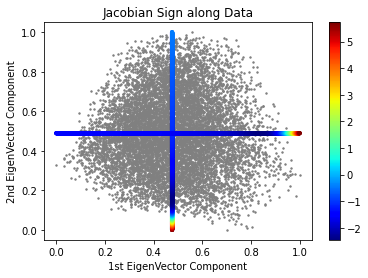

In [ ]:
import pandas as pd
## Eig --> Eff_par

x0 = eig.iloc[:, 0].values
x1 = eig.iloc[:, 1].values
x2 = eig.iloc[:, 2].values

range0 = np.linspace(x0.min(), x0.max(), 3000)
range1 = np.linspace(x1.min(), x1.max(), 3000)
range2 = np.linspace(x2.min(), x2.max(), 3000)

# scatter points along problematic component axes
plt.scatter(x0, x1, s=2, c='grey')
plt.xlabel('1st EigenVector Component')
plt.ylabel('2nd EigenVector Component')
plt.title('Jacobian Sign along Data')

jac0 = np.array(jac0)
jac1 = np.array(jac1)

# scaled_jac0 = jac0 / jac0.ptp()
# scaled_jac1 = jac1 / jac1.ptp()

# colors0 = plt.cm.coolwarm(scaled_jac0)
# colors1 = plt.cm.coolwarm(scaled_jac1)

#m = plt.cm.ScalarMappable(cmap=cm.jet)


# plot the jacobian sign using a colormap
plt.scatter([x0.mean()]*3000, range1, s=10, c=jac0, cmap="jet")
plt.scatter(range0, [x1.mean()]*3000, s=10, c=jac1, cmap="jet")
plt.colorbar()

plt.savefig('CloudPlot')

In [ ]:
print(type(jac0))

<class 'list'>
